In [92]:
import detect as dt
import cv2
import numpy as np
import torch
import torch.nn.functional as F
import torchvision.transforms as transforms, datasets
from model import Net  # Make sure to place model.py in your working directory
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
import os


8 8
8


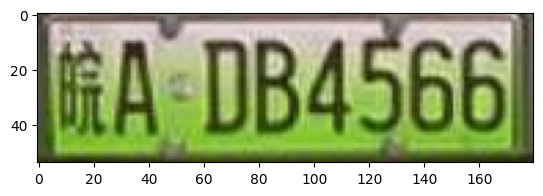

In [78]:
# 读取图像并分割
image_path = './test/carplate.png'
plt.imshow(cv2.imread(image_path))
mats = dt.segment_plate_chars(image_path)
print(len(mats))
# for img in mats:
#     plt.imshow(img)
#     plt.show()

In [77]:
# Load the model
model = Net()
model.load_state_dict(torch.load('./mnist_cnn.pt', map_location=torch.device('cuda')))
model.eval()  # 设置为评估模式

# 定义转换操作，以适应模型训练时的图像格式
transform = transforms.Compose([
    transforms.ToPILImage(),  # 将numpy数组转换为PIL图像
    transforms.Resize((28, 28)),  # 将图像大小调整为28x28像素
    transforms.ToTensor(),  # 将PIL图像转换为PyTorch张量
    transforms.Normalize((0.1307,), (0.3081,))  # 标准化，这些值用于MNIST图像
])

# 推理函数
def infer_character(model, image_np):
    # 确保图像是单通道的灰度图
    if len(image_np.shape) == 3 and image_np.shape[2] == 3:
        image_np = cv2.cvtColor(image_np, cv2.COLOR_BGR2GRAY)
        image_np = dt.resize_with_padding(image_np, 28,28,target_value=image_np[0,0])
        # print(image_np[0,0])
        if image_np[0,0] >200:
            image_np = cv2.bitwise_not(image_np)
        
    # 将numpy图像转换为PIL图像，然后应用定义好的转换操作
    image_tensor = transform(image_np)
    image_tensor = image_tensor.unsqueeze(0)  # 添加一个批处理维度

    # 执行推理
    with torch.no_grad():
        output = model(image_tensor)
        print(F.softmax(output, dim=1).max())
        if F.softmax(output, dim=1).max() < 0.5:
            return -1
        prediction = output.argmax(dim=1, keepdim=True)  # 获得最大概率的索引
        # 输出概率
        
        
    return prediction.item()


# 预测车牌号
plate_number = ''
for image_np in mats:  # 假设mats是一个包含了所有字符图像的numpy数组列表
    digit = infer_character(model, image_np)
    # plt.imshow(image_np)
    # plt.show()
    plate_number += str(digit) if digit >= 0 else 'X'

print('车牌号码是:', plate_number)

tensor(0.3864)
tensor(0.6951)
tensor(0.3836)
tensor(0.9239)
tensor(0.3700)
tensor(0.4792)
tensor(0.6641)
tensor(0.6139)
车牌号码是: X1X8XX88


In [73]:


# mat2vector函数的Python版本
def mat2vector(data):
    if len(data.shape) > 2:
        data = cv2.cvtColor(data, cv2.COLOR_BGR2GRAY)
    return data.flatten()

def template_matching(sample, templates):
    distances = cdist(sample, templates, 'euclidean')
    min_distance = np.min(distances)
    best_match = np.argmin(distances)
    return min_distance, best_match

# 读取模板并将其转化为向量
templates = []
for i in range(10):
    filename = f'./tamplates/char_{i}.png' 
    template = cv2.imread(filename, 0)
    template = cv2.resize(template, (28, 28))
    templates.append(mat2vector(template))

templates = np.array(templates)

# 测试样本
correct_num = 0
plate_number = ''
for sample in mats:
    sample = cv2.resize(sample, (28, 28))
    sample_vector = mat2vector(sample).reshape(1, -1)

    min_distance, best_match = template_matching(sample_vector, templates)
    plate_number += str(best_match) if min_distance < 2000 else 'X'
    
if plate_number == 'XXXXXXX':
    plate_number = ''
    for sample in mats:
        sample = cv2.resize(sample, (28, 28))
        sample = cv2.bitwise_not(sample)
        sample_vector = mat2vector(sample).reshape(1, -1)

        min_distance, best_match = template_matching(sample_vector, templates)
        plate_number += str(best_match) if min_distance < 2000 else 'X'
    
print('车牌号码是:', plate_number)



车牌号码是: XXX0235


In [93]:

transform = transforms.Compose([transforms.ToTensor()])

train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('./data', train=False, transform=transform)

templates = {}
for i in range(10):
    templates[i] = []  

N = 50 
for image, label in train_dataset:
    if len(templates[label]) < N:
        image = image.numpy().squeeze()
        templates[label].append(image)
    if all(len(templates[digit]) == N for digit in range(10)):
        break 

def match_template(image, templates):
    image = image.numpy().squeeze()
    matching_scores = []

    for digit, temps in templates.items():
        for temp in temps:
            res = cv2.matchTemplate(image, temp, cv2.TM_CCOEFF)
            min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)
            matching_scores.append((max_val, digit))
    matching_scores.sort(key=lambda x: x[0], reverse=True)
    return matching_scores[0][1]
correct_predictions = 0
total_predictions = 0

for image, true_label in test_dataset:
    predicted_label = match_template(image, templates)
    if predicted_label == true_label:
        correct_predictions += 1
    total_predictions += 1


accuracy = correct_predictions / total_predictions
print(f'Accuracy in MNIST by Matchtemplate: {accuracy * 100:.2f}%')


# 文件夹路径
folder_path = './test_carplate_num/'
correct_predictions = 0
total_predictions = 0

# 遍历文件夹
for filename in os.listdir(folder_path):
    if filename.endswith(".png"):  # 假设所有图像都是PNG格式
        # 读取图像文件
        image_path = os.path.join(folder_path, filename)
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        import detect as dt
        image = dt.resize_with_padding(image, 28,28,target_value=image[0,0])
        image = torch.tensor(image, dtype=torch.float32) / 255.0  # 归一化

        # 对图像应用模板匹配
        predicted_label = match_template(image, templates)

        # 从文件名获取真实标签（假设文件名以真实数字开头）
        true_label = int(filename.split('_')[1].split('.')[0])  # 从 "char_{i}.png" 中提取数字

        # 更新统计
        if predicted_label == true_label:
            correct_predictions += 1
        total_predictions += 1

# 计算正确率
accuracy = correct_predictions / total_predictions if total_predictions > 0 else 0
print(f'Accuracy of Carplate Number by Matchtemplate: {accuracy * 100:.2f}%')




Accuracy in MNIST by Matchtemplate: 78.66%
Accuracy of Carplate Number by Matchtemplate: 30.00%


In [95]:
# Load the model
model = Net()
model.load_state_dict(torch.load('./mnist_cnn.pt', map_location=torch.device('cuda')))
model.eval()  # 设置为评估模式

# 定义转换操作，以适应模型训练时的图像格式
transform = transforms.Compose([
    transforms.ToPILImage(),  # 将numpy数组转换为PIL图像
    transforms.Resize((28, 28)),  # 将图像大小调整为28x28像素
    transforms.ToTensor(),  # 将PIL图像转换为PyTorch张量
    transforms.Normalize((0.1307,), (0.3081,))  # 标准化，这些值用于MNIST图像
])

# 推理函数
def infer_character(model, image_np):
    # 确保图像是单通道的灰度图
    if len(image_np.shape) == 3 and image_np.shape[2] == 3:
        image_np = cv2.cvtColor(image_np, cv2.COLOR_BGR2GRAY)
        image_np = dt.resize_with_padding(image_np, 28,28,target_value=image_np[0,0])
        # print(image_np[0,0])
        if image_np[0,0] >200:
            image_np = cv2.bitwise_not(image_np)
        
    # 将numpy图像转换为PIL图像，然后应用定义好的转换操作
    image_tensor = transform(image_np)
    image_tensor = image_tensor.unsqueeze(0)  # 添加一个批处理维度

    # 执行推理
    with torch.no_grad():
        output = model(image_tensor)
        if F.softmax(output, dim=1).max() < 0.5:
            return -1
        prediction = output.argmax(dim=1, keepdim=True)  # 获得最大概率的索引
        # 输出概率
        
        
    return prediction.item()


correct_predictions=0
total_predictions=0
for image, true_label in test_dataset:
    predicted_label = infer_character(model, image)
    if predicted_label == true_label:
        correct_predictions += 1
    total_predictions += 1
    
accuracy = correct_predictions / total_predictions
print(f'Accuracy in MNIST by CNN: {accuracy * 100:.2f}%')

# 文件夹路径
folder_path = './test_carplate_num/'
correct_predictions = 0
total_predictions = 0

# 遍历文件夹
for filename in os.listdir(folder_path):
    if filename.endswith(".png"):  # 假设所有图像都是PNG格式
        # 读取图像文件
        image_path = os.path.join(folder_path, filename)
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        import detect as dt
        image = dt.resize_with_padding(image, 28,28,target_value=image[0,0])
        image = torch.tensor(image, dtype=torch.float32) / 255.0  # 归一化

        #应用CNN模型
        predicted_label = infer_character(model, image)
        

        # 从文件名获取真实标签（假设文件名以真实数字开头）
        true_label = int(filename.split('_')[1].split('.')[0])  # 从 "char_{i}.png" 中提取数字

        # 更新统计
        if predicted_label == true_label:
            correct_predictions += 1
        total_predictions += 1

# 计算正确率
accuracy = correct_predictions / total_predictions if total_predictions > 0 else 0
print(f'Accuracy of Carplate Number by CNN: {accuracy * 100:.2f}%')

Accuracy in MNIST by CNN: 99.00%
Accuracy of Carplate Number by CNN: 90.00%
